In [22]:
# to read nsp file we would need nsp reading module so for this we would be using nspfile
!pip install nspfile

In [31]:
#reading nsp file trying out first single nsp file
import nspfile
fs, x = nspfile.read(r"C:\Users\Singh\Downloads\Amyotrophe Lateralsklerose\2373\vowels\2373-a_h.nsp")

In [32]:
fs

50000

In [33]:
x

array([[-307],
       [ -40],
       [ 187],
       ...,
       [-510],
       [-739],
       [-931]], shape=(29255, 1), dtype=int16)

In [34]:
x = x.squeeze()

In [35]:
x

array([-307,  -40,  187, ..., -510, -739, -931],
      shape=(29255,), dtype=int16)

# extracting acoustic features using scipy

In [37]:
import numpy as np
from scipy.signal import welch
from scipy.fft import rfft,rfftfreq

def extract_features(x,fs):
    x = x.astype(float)
    energy = np.sum(x**2)/len(x)

    zcr = np.mean(np.abs(np.diff(np.sign(x))))/2

    spectrum = np.abs(rfft(x))
    freqs = rfftfreq(len(x),1/fs)
    spectral_centroid = np.sum(freqs*spectrum)/np.sum(spectrum)

    spectral_bandwidth = np.sqrt(np.sum(((freqs-spectral_centroid)**2)*spectrum)/np.sum(spectrum))
    f, Pxx = welch(x, fs, nperseg=1024)
    dominant_freq = f[np.argmax(Pxx)]

    return {
        "energy": energy,
        "zcr": zcr,
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        "dominant_freq": dominant_freq
    }

features = extract_features(x, fs)
print(features)

{'energy': np.float64(16201124.140454624), 'zcr': np.float64(0.029329322485813904), 'spectral_centroid': np.float64(1277.7858698886864), 'spectral_bandwidth': np.float64(2029.040534971637), 'dominant_freq': np.float64(878.9062499999999)}


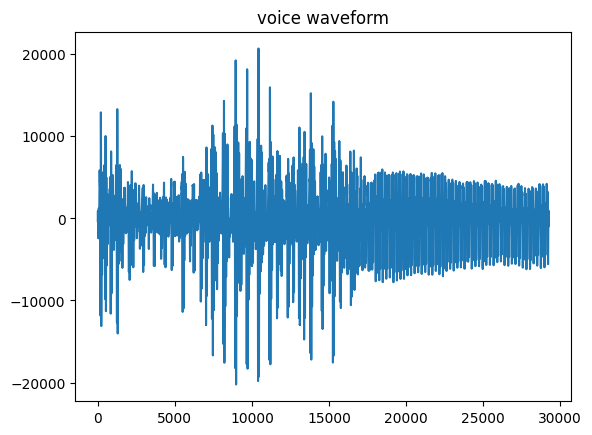

In [40]:
import matplotlib.pyplot as plt
plt.plot(x)
plt.title("voice waveform")
plt.show()

# combining all functions together

In [2]:
import os
import nspfile
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.fft import rfft, rfftfreq


def extract_features(x, fs):
    x = x.astype(float)
    energy = np.sum(x ** 2) / len(x)
    zcr = np.mean(np.abs(np.diff(np.sign(x)))) / 2

    spectrum = np.abs(rfft(x))
    freqs = rfftfreq(len(x), 1 / fs)
    spectral_centroid = np.sum(freqs * spectrum) / np.sum(spectrum)
    spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid) ** 2) * spectrum) / np.sum(spectrum))

    f, Pxx = welch(x, fs, nperseg=1024)
    dominant_freq = f[np.argmax(Pxx)]

    return {
        "energy": energy,
        "zcr": zcr,
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        "dominant_freq": dominant_freq
    }


def process_dataset(disorder_path, disorder_name):
    rows = []
    for root, _, files in os.walk(disorder_path):
        for file in files:
            if file.endswith(".nsp"):
                file_path = os.path.join(root, file)
                try:
                    fs, x = nspfile.read(file_path)
                    x = x.squeeze()
                    feats = extract_features(x, fs)
                    feats["file"] = file
                    feats["subject_id"] = os.path.basename(os.path.dirname(root))
                    feats["disorder"] = disorder_name
                    rows.append(feats)
                except Exception as e:
                    print("Error processing:", file_path, "Reason:", e)
    return rows


base_dir = r"C:\Users\Singh\Downloads\dataset"
all_data = []

for disorder in os.listdir(base_dir):
    disorder_path = os.path.join(base_dir, disorder)
    if os.path.isdir(disorder_path):
        print("Processing:", disorder)
        data = process_dataset(disorder_path, disorder)
        all_data.extend(data)


df = pd.DataFrame(all_data)
df.to_csv("voice_disorders_dataset.csv", index=False)

print("Done. Total samples:", len(df))
print("Saved as voice_disorders_dataset.csv")


Processing: Amyotrophe Lateralsklerose
Processing: aryluxation
Done. Total samples: 112
Saved as voice_disorders_dataset.csv


In [3]:
import pandas as pd

df = pd.read_csv("voice_disorders_dataset.csv")
print(df.head())
print(df["disorder"].value_counts())


         energy       zcr  spectral_centroid  spectral_bandwidth  \
0  1.518906e+07  0.009069        1449.899268         2936.172342   
1  2.603057e+07  0.024681        1343.657304         2308.933063   
2  1.108989e+07  0.025184        1803.686271         3083.401977   
3  2.244756e+07  0.027443        1320.330000         2224.638847   
4  2.370225e+07  0.019580        2230.693225         3729.824690   

   dominant_freq             file  subject_id                    disorder  
0     146.484375  1242-phrase.nsp        1242  Amyotrophe Lateralsklerose  
1     585.937500     1242-a_h.nsp        1242  Amyotrophe Lateralsklerose  
2     146.484375     1242-a_l.nsp        1242  Amyotrophe Lateralsklerose  
3     585.937500   1242-a_lhl.nsp        1242  Amyotrophe Lateralsklerose  
4     146.484375     1242-a_n.nsp        1242  Amyotrophe Lateralsklerose  
disorder
aryluxation                   84
Amyotrophe Lateralsklerose    28
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["file", "subject_id", "disorder"])
y = df["disorder"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


                            precision    recall  f1-score   support

Amyotrophe Lateralsklerose       0.80      0.67      0.73         6
               aryluxation       0.89      0.94      0.91        17

                  accuracy                           0.87        23
                 macro avg       0.84      0.80      0.82        23
              weighted avg       0.87      0.87      0.87        23

[[ 4  2]
 [ 1 16]]


# fixing data imbalance, as there is bias towards aryluxation

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight=class_weights
)
model.fit(X_train_scaled, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
#retraining model
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


                            precision    recall  f1-score   support

Amyotrophe Lateralsklerose       0.80      0.67      0.73         6
               aryluxation       0.89      0.94      0.91        17

                  accuracy                           0.87        23
                 macro avg       0.84      0.80      0.82        23
              weighted avg       0.87      0.87      0.87        23



In [15]:
import numpy as np
from scipy.fft import rfft, rfftfreq
from scipy.signal import welch
import parselmouth
from python_speech_features import mfcc

def extract_advanced_features(x, fs):
    x = x.astype(float)

   
    energy = np.sum(x ** 2) / len(x)
    zcr = np.mean(np.abs(np.diff(np.sign(x)))) / 2
    spectrum = np.abs(rfft(x))
    freqs = rfftfreq(len(x), 1 / fs)
    spectral_centroid = np.sum(freqs * spectrum) / np.sum(spectrum)
    spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid) ** 2) * spectrum) / np.sum(spectrum))
    f, Pxx = welch(x, fs, nperseg=1024)
    dominant_freq = f[np.argmax(Pxx)]

   
    mfcc_feat = mfcc(x, samplerate=fs, numcep=13, nfft=2048)
    mfcc_mean = np.mean(mfcc_feat, axis=0)
    mfcc_std = np.std(mfcc_feat, axis=0)

   
    snd = parselmouth.Sound(values=x, sampling_frequency=fs)
    pointProcess = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", 75, 600)
    jitter_local = parselmouth.praat.call(pointProcess, "Get jitter (local)", 0, 0.02, 1.3)
    shimmer_local = parselmouth.praat.call([snd, pointProcess], "Get shimmer (local)", 0, 0.02, 1.3, 1.6)
    hnr = parselmouth.praat.call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0).get_mean()

 
    features = {
        "energy": energy,
        "zcr": zcr,
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        "dominant_freq": dominant_freq,
        "jitter": jitter_local,
        "shimmer": shimmer_local,
        "hnr": hnr
    }

    for i in range(13):
        features[f"mfcc_mean_{i+1}"] = mfcc_mean[i]
        features[f"mfcc_std_{i+1}"] = mfcc_std[i]

    return features


In [16]:
import os
import numpy as np
import pandas as pd
from scipy.fft import rfft, rfftfreq
from scipy.signal import welch
import parselmouth
from python_speech_features import mfcc
import nspfile



def extract_advanced_features(x, fs):
    x = x.astype(float)

 
    energy = np.sum(x ** 2) / len(x)
    zcr = np.mean(np.abs(np.diff(np.sign(x)))) / 2
    spectrum = np.abs(rfft(x))
    freqs = rfftfreq(len(x), 1 / fs)
    spectral_centroid = np.sum(freqs * spectrum) / np.sum(spectrum)
    spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid) ** 2) * spectrum) / np.sum(spectrum))
    f, Pxx = welch(x, fs, nperseg=1024)
    dominant_freq = f[np.argmax(Pxx)]

   
    mfcc_feat = mfcc(x, samplerate=fs, numcep=13, nfft=2048)
    mfcc_mean = np.mean(mfcc_feat, axis=0)
    mfcc_std = np.std(mfcc_feat, axis=0)

   
    try:
        snd = parselmouth.Sound(values=x, sampling_frequency=fs)
        pointProcess = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", 75, 600)

       
        jitter_local = parselmouth.praat.call(pointProcess, "Get jitter (local)", 0.0, 0.02, 0.4)
        shimmer_local = parselmouth.praat.call([snd, pointProcess], "Get shimmer (local)", 0.0, 0.02, 0.4, 1.6)

        hnr_object = parselmouth.praat.call(snd, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
        hnr = parselmouth.praat.call(hnr_object, "Get mean", 0, 0)
    except Exception:
        jitter_local = np.nan
        shimmer_local = np.nan
        hnr = np.nan


    features = {
        "energy": energy,
        "zcr": zcr,
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        "dominant_freq": dominant_freq,
        "jitter": jitter_local,
        "shimmer": shimmer_local,
        "hnr": hnr
    }

    for i in range(13):
        features[f"mfcc_mean_{i+1}"] = mfcc_mean[i]
        features[f"mfcc_std_{i+1}"] = mfcc_std[i]

    return features



def process_dataset(disorder_path, disorder_name):
    rows = []
    for root, _, files in os.walk(disorder_path):
        for file in files:
            if file.endswith(".nsp"):
                file_path = os.path.join(root, file)
                try:
                    fs, x = nspfile.read(file_path)
                    x = x.squeeze()
                    feats = extract_advanced_features(x, fs)
                    feats["file"] = file
                    feats["subject_id"] = os.path.basename(os.path.dirname(root))
                    feats["disorder"] = disorder_name
                    rows.append(feats)
                except Exception as e:
                    print("Error processing:", file_path, "Reason:", e)
    return rows


base_dir = r"C:\Users\Singh\Downloads\dataset"
all_data = []

for disorder in os.listdir(base_dir):
    disorder_path = os.path.join(base_dir, disorder)
    if os.path.isdir(disorder_path):
        print("Processing:", disorder)
        data = process_dataset(disorder_path, disorder)
        all_data.extend(data)

df = pd.DataFrame(all_data)
df.to_csv("voice_disorders_dataset_advanced.csv", index=False)

print("Done. Total samples:", len(df))
print("Saved as voice_disorders_dataset_advanced.csv")


Processing: Amyotrophe Lateralsklerose
Processing: aryluxation
Done. Total samples: 112
Saved as voice_disorders_dataset_advanced.csv


In [17]:
import pandas as pd
df = pd.read_csv("voice_disorders_dataset_advanced.csv")
print(df.shape)
print(df.columns[:10])
print(df.head(3))


(112, 37)
Index(['energy', 'zcr', 'spectral_centroid', 'spectral_bandwidth',
       'dominant_freq', 'jitter', 'shimmer', 'hnr', 'mfcc_mean_1',
       'mfcc_std_1'],
      dtype='object')
         energy       zcr  spectral_centroid  spectral_bandwidth  \
0  1.518906e+07  0.009069        1449.899268         2936.172342   
1  2.603057e+07  0.024681        1343.657304         2308.933063   
2  1.108989e+07  0.025184        1803.686271         3083.401977   

   dominant_freq  jitter  shimmer  hnr  mfcc_mean_1  mfcc_std_1  ...  \
0     146.484375     NaN      NaN  NaN    16.209669    1.349518  ...   
1     585.937500     NaN      NaN  NaN    18.187002    0.938179  ...   
2     146.484375     NaN      NaN  NaN    17.405964    0.327244  ...   

   mfcc_std_10  mfcc_mean_11  mfcc_std_11  mfcc_mean_12  mfcc_std_12  \
0    11.682684      2.011969     8.372006     10.979438     7.641360   
1     5.765675    -21.383006     6.850524     -6.817591     4.354450   
2     6.908650     -4.591053     6

In [18]:
#random forest

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib

df = pd.read_csv("voice_disorders_dataset_advanced.csv")


X = df.drop(columns=["file", "subject_id", "disorder"])
y = df["disorder"]


X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))


model = RandomForestClassifier(
    n_estimators=400,
    max_depth=14,
    min_samples_split=3,
    random_state=42,
    class_weight=class_weights
)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

joblib.dump(model, "voice_disorder_model_advanced.pkl")
joblib.dump(scaler, "voice_disorder_scaler.pkl")

print("Model and scaler saved successfully.")


C:\Users\Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Classification Report:
                            precision    recall  f1-score   support

Amyotrophe Lateralsklerose       0.75      0.50      0.60         6
               aryluxation       0.84      0.94      0.89        17

                  accuracy                           0.83        23
                 macro avg       0.80      0.72      0.74        23
              weighted avg       0.82      0.83      0.81        23

Confusion Matrix:
[[ 3  3]
 [ 1 16]]
Model and scaler saved successfully.


In [19]:
!pip install xgboost tensorflow


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 8.5 MB/s eta 0:00:09
   - -------------------------------------- 1.8/72.0 MB 4.8 MB/s eta 0:00:15
   - -------------------------------------- 2.1/72.0 MB 4.7 MB/s eta 0:00:15
   - -------------------------------------- 3.4/72.0 MB 4.3 MB/s eta 0:00:16
   -- ------------------------------------- 4.2/72.0 MB 4.1 MB/s eta 0:00:17
   -- ------------------------------------- 5.0/72.0 MB 4.1 MB/s eta 0:00:17
   --- ------------------------------------ 5.8/72.0 MB 4.1 MB/s eta 0:00:17
   --- ------------------------------------ 6.6/72.0 MB 4.1 MB/s eta 0:00:17
   ---- ----------------------------------- 7.3/72.0 MB 4.0 MB/s eta 0:00:16
   ---- ----------------------------------- 8.1/72.0 MB 4.0 MB/s eta 0:00:16
   ---- ----------------------------------- 8.9/72.0 MB 4.0 MB/s eta 0:00:16
   ----- ---------------------------------- 9.7/72.0 MB 4.0 MB/s eta 0:00:16
   ---

Training: Logistic Regression

 Logistic Regression
                            precision    recall  f1-score   support

Amyotrophe Lateralsklerose       1.00      0.67      0.80         6
               aryluxation       0.89      1.00      0.94        17

                  accuracy                           0.91        23
                 macro avg       0.95      0.83      0.87        23
              weighted avg       0.92      0.91      0.91        23

----------------------------------------------------------------------
Training: SVM (RBF Kernel)

 SVM (RBF Kernel)
                            precision    recall  f1-score   support

Amyotrophe Lateralsklerose       1.00      0.50      0.67         6
               aryluxation       0.85      1.00      0.92        17

                  accuracy                           0.87        23
                 macro avg       0.93      0.75      0.79        23
              weighted avg       0.89      0.87      0.85        23

---------

C:\Users\Singh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:56:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


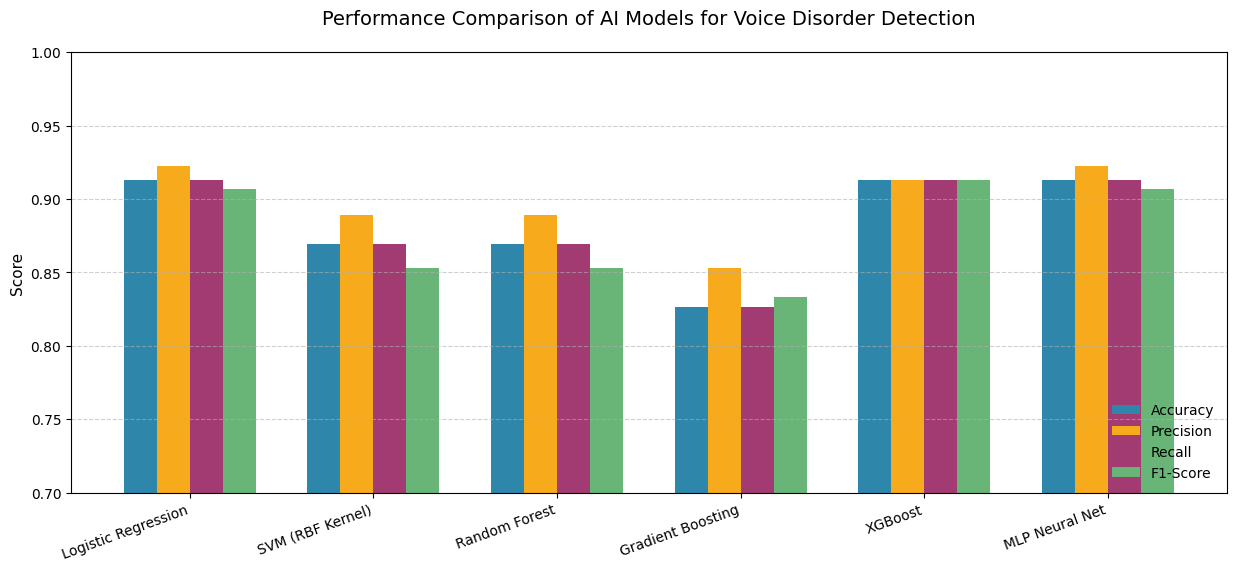


High-resolution plot saved as:
AI_Model_Performance_Comparison.png and .svg


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import matplotlib.pyplot as plt


df = pd.read_csv("voice_disorders_dataset_advanced.csv")

X = df.drop(columns=["file", "subject_id", "disorder"])
y = df["disorder"]


X = X.fillna(X.mean())
X = X.fillna(0)

-
le = LabelEncoder()
y_encoded = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM (RBF Kernel)": SVC(kernel="rbf", C=2, gamma="scale", probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=400, max_depth=14, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5),
    "XGBoost": xgb.XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=5, eval_metric="logloss", use_label_encoder=False),
    "MLP Neural Net": MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", max_iter=500)
}


results = []

for name, model in models.items():
    print("Training:", name)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    
    results.append([name, acc, prec, rec, f1])
    
    y_pred_decoded = le.inverse_transform(y_pred)
    y_test_decoded = le.inverse_transform(y_test)
    
    print("\n", name)
    print(classification_report(y_test_decoded, y_pred_decoded))
    print("-" * 70)

---
metrics = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])


plt.figure(figsize=(13, 7))
bar_width = 0.18
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.bar(r1, metrics["Accuracy"], width=bar_width, color="#2E86AB", label="Accuracy")
plt.bar(r2, metrics["Precision"], width=bar_width, color="#F6AA1C", label="Precision")
plt.bar(r3, metrics["Recall"], width=bar_width, color="#A23B72", label="Recall")
plt.bar(r4, metrics["F1-Score"], width=bar_width, color="#69B578", label="F1-Score")


plt.xticks(
    [r + bar_width * 1.5 for r in range(len(metrics))],
    metrics["Model"],
    rotation=20,
    ha="right",
    fontsize=10
)

plt.ylabel("Score", fontsize=11)
plt.title("Performance Comparison of AI Models for Voice Disorder Detection", fontsize=14, pad=20)
plt.ylim(0.7, 1.0)
plt.legend(fontsize=10, loc="lower right", frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout(pad=3.0)
plt.subplots_adjust(bottom=0.25)


plt.savefig("AI_Model_Performance_Comparison.png", dpi=400, bbox_inches="tight")
plt.savefig("AI_Model_Performance_Comparison.svg", dpi=400, bbox_inches="tight")  

plt.show()

print("\nHigh-resolution plot saved as:")
print("AI_Model_Performance_Comparison.png and .svg")
